In [1]:
import deepxde as dde
import numpy as np
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pylab
from numpy import linalg as LA
import math
import scipy.io
from os.path import dirname, join as pjoin
from scipy.stats import truncnorm
# import tensorflow as tf


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term






In [2]:
params = {'backend': 'ps',
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'legend.handlelength': 1,
          'legend.borderaxespad': 0,
          'font.family': 'serif',
          'font.serif': ['Computer Modern Roman'],
          'ps.usedistiller': 'xpdf',
          'text.usetex': True,
          # include here any neede package for latex
          'text.latex.preamble': [r'\usepackage{amsmath}'],
          }
plt.rcParams.update(params)
plt.style.use('seaborn-white')

/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [3]:
if dde.backend.backend_name == "pytorch":
    exp = dde.backend.torch.exp
else:
    from deepxde.backend import tf

    exp = tf.exp


In [4]:
S3 = dde.Variable(1.0)

In [5]:

def pde(x, y):
    
    """Self assembly system.
    dy1_t = 1/2*(y3^2)-dy1_x*D1-dy1_xx*D2
    dy2_t = -dD1y2_x +dD2y2_xx
    y3=dy1_x*dD1_y3+dy1_xx*dD2_y3
    All collocation-based residuals are defined here
    Including a penalty function for negative solutions
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_t = dde.grad.jacobian(y1, x, j=1)
    dy1_x = dde.grad.jacobian(y1, x, j=0)
    dy1_xx = dde.grad.hessian(y1, x, j=0)

    D2=d*tf.math.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3))+f
    F=a*K*T*(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)
#     dD2_x=dde.grad.jacobian(D2, x, j=0)
#     dF_x=dde.grad.jacobian(F, x, j=0)
#     D1=dD2_x-dF_x*(D2/(K*T))
    D1=-2*(x[:, 0:1]-b-c*y3)*((d*tf.math.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)))+a*D2)
    dy2_t = dde.grad.jacobian(y2, x, j=1)
    dD1y2_x=dde.grad.jacobian(D1*y2, x, j=0)
    dD2y2_xx = dde.grad.hessian(D2*y2, x,  j=0)
    dD1_y3=dde.grad.jacobian(D1, y3)
    dD2_y3=dde.grad.jacobian(D2, y3)
    tt=100

    
    
    return [
        dy1_t-.5*(S3*y3*S3*y3)+D1*dy1_x+D2*dy1_xx,
        dy2_t+dD1y2_x-dD2y2_xx,
        S3*y3-dy1_x*dD1_y3-dy1_xx*dD2_y3,
#         neg_loss,
#         neg_loss_y2,
    ]


In [6]:
def boundary(_, on_initial):
    return on_initial


def pdf1d_T(x):
    mu = 5.
    sigma = .1
    a, b = (0. - mu) / sigma, (6. - mu) / sigma
    rho_T=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)
    return rho_T


def pdf1d_0(x):
    sigma = .2
    mu=0.
    a, b = (0. - mu) / sigma, (6. - mu) / sigma
    rho_0=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)
    return rho_0


# def modify_output(X, Y):
#     y1, y2, y3  = Y[:, 0:1], Y[:, 1:2], Y[:, 2:3]
#     u_new = tf.clip_by_value(y3, clip_value_min = .5, clip_value_max = 4)
#     return tf.concat((y1, y2, u_new), axis=1)


In [7]:

x_T = np.transpose(np.linspace(0., 6., 1000))
T_t=200. #Terminal time
x_T=x_T.reshape(len(x_T),1)
time=T_t*np.ones(( 1,len(x_T))).reshape(len(x_T),1)
rho_T=pdf1d_T(x_T).reshape(len(x_T),1)

terminal_time=np.hstack((x_T,time))
rho_T_BC = dde.icbc.PointSetBC(terminal_time, rho_T, component=1)

a, b, c, d, f= 10., 2.1, 0.75, .0045, 0.0005

K, T=1.38066*10**-23, 293.

geom = dde.geometry.Interval(0., 6.)
timedomain = dde.geometry.TimeDomain(0., T_t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
rho_0_BC = dde.icbc.IC(geomtime, lambda x: pdf1d_0(x[:,0:1]) , boundary, component=1)


In [8]:
data = dde.data.TimePDE(geomtime, pde,  [rho_0_BC,rho_T_BC], num_domain=5000, num_initial=500)
net = dde.nn.FNN([2] + [70] *3  + [3], "tanh", "Glorot normal")
# net.apply_output_transform(modify_output)
# net.apply_output_transform(modify_output)
model = dde.Model(data, net)


/opt/anaconda3/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5002=5002. 
  warnings.warn("The balance properties of Sobol' points require "
/opt/anaconda3/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  warnings.warn("The balance properties of Sobol' points require "


In [9]:
loss_func=["MSE","MSE","MSE","wass","MSE"]
model.compile("adam", lr=1e-3,loss=loss_func)
losshistory, train_state = model.train(epochs=15000)



Compiling model...
Building feed-forward neural network...
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
'build' took 0.078685 s

'compile' took 2.038742 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [8.65e-02, 9.48e-04, 5.45e-01, 9.75e-01, 7.07e-01]    [8.65e-02, 9.48e-04, 5.45e-01, 9.75e-01, 7.07e-01]    []  
1000      [1.17e-05, 1.76e-02, 3.89e-04, 4.08e-03, 2.78e-02]    [1.17e-05, 1.76e-02, 3.89e-04, 4.08e-03, 2.78e-02]    []  
2000      [1.17e-05, 6.89e-03, 2.21e-04, 1.04e-04, 2.30e-03]    [1.17e-05, 6.89e-03, 2.21e-04, 1.04e-04, 2.30e-03]    []  
3000      [6.76e-06, 4.67e-03, 1.11e-04, 4.23e-05, 6.22e-03]    [6.76e-06, 4.67e-03, 1.11e-04, 4.23e-05, 6.22e-03]    []  
4000      [5.24e-06, 6.32e-03, 1.61e-04, 1.38e-05, 8.29e-03]    [5.24e-06, 6.32e-03, 1.61e-0

Saving loss history to /Users/inodozi/Documents/GitHub/SelfAssembly/Code/loss.dat ...
Saving training data to /Users/inodozi/Documents/GitHub/SelfAssembly/Code/train.dat ...
Saving test data to /Users/inodozi/Documents/GitHub/SelfAssembly/Code/test.dat ...


RuntimeError: latex was not able to process the following string:
b'# Steps'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/inodozi/.matplotlib/tex.cache/84409fec8557e2e78e526796bc8ba281.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./84409fec8557e2e78e526796bc8ba281.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.19 {\sffamily #
                  Steps}
No pages of output.
Transcript written on 84409fec8557e2e78e526796bc8ba281.log.




<Figure size 432x288 with 1 Axes>

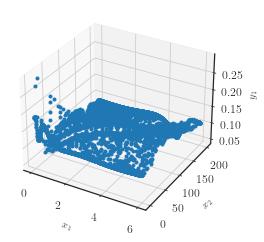

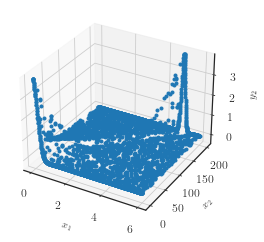

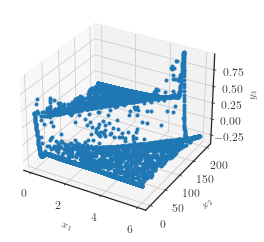

In [19]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)